In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys, io, re, time
from glob import glob
from collections import OrderedDict
import itertools
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.persistence import RailEnvPersister
from flatland.utils.rendertools import RenderTool
import flatland.utils.jupyter_utils as ju
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML
from ipywidgets import Button, HBox, VBox
from flatland_contrib.graphs.graph_utils import RailEnvGraph, trans_int_to_4x4, trans_int_to_binstr, trans_int_to_nesw, get_rail_transitions_df
from flatland_contrib.graphs.graph_utils import get_simple_path, plotGraphEnv
import flatland_contrib.graphs.graph_utils as gu
# from flatland.envs.rail_generators import rail_from_manual_specifications_generator
#from flatland.envs.rail_generators import random_rail_generator, complex_rail_generator, sparse_rail_generator, empty_rail_generator
from flatland.envs.rail_generators import sparse_rail_generator, empty_rail_generator
from flatland.envs.observations import GlobalObsForRailEnv
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters

In [3]:
from flatland.utils import env_edit_utils as eeu
from flatland.utils import jupyter_utils as ju
import ipywidgets as ipw

In [4]:
#import torch
#from torch import tensor
#from functools import partial
#from flatland_contrib.graphs  import graphpath as gp
#from ijsolution import graphpath as gp
#from ijsolution import PathUtils as pu

In [5]:
#display(HTML("<style>.container { width:80% !important; }</style>"))

In [6]:
dfMD = pd.read_csv("../../jeremyw/scratch/test-envs/metadata.csv")
dfMD2 = dfMD[["test_id", "n_agents", "x_dim", "y_dim"]] # , "max_rails_in_city", "max_rails_between_cities" ]]

In [7]:
dfMD2.drop_duplicates()[:5]

,test_id,n_agents,x_dim,y_dim
0,Test_0,1,25,25
10,Test_1,2,25,25
20,Test_2,3,25,25
30,Test_3,4,25,25
40,Test_4,5,25,25


In [8]:
#sDirEnvs = "../../neurips2020-flatland-scoring/environments/neurips2020_round_2_v6_final/debug/"
#sDirEnvs = "../../neurips2020-flatland-starter-kit/scratch/test-envs/"
sDirEnvs = "../../jeremyw/scratch/test-envs/"
lsTests = glob(sDirEnvs + "Test_*")
lsTests.sort(key=lambda s: int(os.path.basename(s)[5:]))  # list of tests eg Test_1, Test_20 sorted in numerical order, ie 1 < 9 < 10 < 20 etc (without expecting leading zeros)

lsTestLev = []
for sDirTest in lsTests:
    lsLevs = glob(sDirTest + "/Lev*")
    lsLevs.sort(key=lambda s: int(os.path.basename(s)[6:-4]))  # sort the levels in numerical order, again without leading zeros
    for sEnv in lsLevs:
        lsTestLev.append(sEnv)
print(len(lsTestLev), lsTestLev[-1])

40 ../../jeremyw/scratch/test-envs/Test_19/Level_1.pkl


In [9]:
if False:
    llMD = []
    for sTestLev in lsTestLev[:50]:
        env, env_dict=RailEnvPersister.load_new(sTestLev)
        lRow = (re.search("/([^/]+)/([^/]+)$", sTestLev)[0], env.width, env.height, len(env.agents), env.malfunction_process_data.malfunction_rate) 
        #print(os.path.basename(sTestLev), env.width, env.height, len(env.agents), env.malfunction_process_data.malfunction_rate)
        llMD.append(lRow)
    pd.DataFrame(llMD, columns=["file", "width", "height", "agents", "mf_rate"])[18:25]

In [10]:
if False:
    #env, envModel = eeu.makeTestEnv("loop_with_loops", nAg=10, bUCF=True)
    #env, envModel = eeu.makeTestEnv(lsEnvNames[3], nAg=10, bUCF=True)
    #env, env_dict=RailEnvPersister.load_new("Test_20_Level_0.pkl")
    iTest = 12 # 30
    sTestLev = lsTestLev[iTest]
    print(sTestLev)
    env, env_dict=RailEnvPersister.load_new(sTestLev)

In [11]:
env, oModel = eeu.makeTestEnv("alternative_needs_pause")

In [12]:
#behaviour = ju.ForwardWithPause(env, [ju.AgentPause(0, 10, 5)])
behaviour = ju.AlwaysForward(env)
oEC = ju.EnvCanvas(env, behaviour, ) #size=(1000,1000))
env.reset(regenerate_rail=False)
oEC.show()
lImages = []

for i in range(25):
    oEC.step()
    oEC.render()
    time.sleep(0.1)
    aImg = oEC.oRT.get_image()
    lImages.append(aImg)

Canvas()

In [13]:
aImg = oEC.oRT.get_image()

In [14]:
type(aImg), aImg.shape

(numpy.ndarray, (314, 624, 4))

In [15]:
oReg = gu.RailEnvGraph(env)
G2 = oReg.graph_rail_grid()

In [16]:
if True:
    #plotGraphEnv(G2, env, aImg)
    plotGraphEnv(oReg.G, env, aImg, figsize=(10,10), node_size=10,
                    node_colors={"rail":"blue", "grid":"red"},
                    edge_colors={"hold":"gray", "dir":"green"},
                    show_nodes=("rail", "grid"),
                    show_edges=("dir", "hold")
                   )
    with io.BytesIO() as fbio:
        plt.savefig(fbio, bbox_inches="tight", pad_inches=0)
        bimgEnv = fbio.getvalue()
    plt.close()

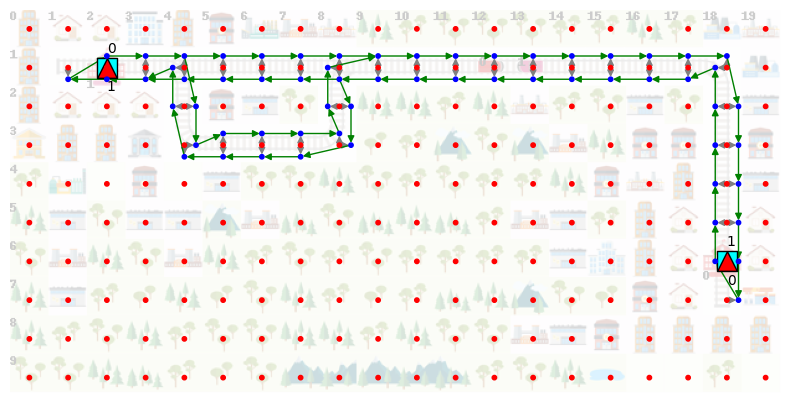

In [17]:
plotGraphEnv(oReg.G, env, aImg, figsize=(10,10), node_size=10,
                    node_colors={"rail":"blue", "grid":"red"},
                    edge_colors={"hold":"gray", "dir":"green"},
                    show_nodes=("rail", "grid"),
                    show_edges=("dir", "hold")
                   )

### Reduced Paths G5
Comment out whether you want G5 "reduced" or the full G2

In [44]:
if False:
    G5 = oReg.reduce_simple_paths()
else:
    G5 = G2


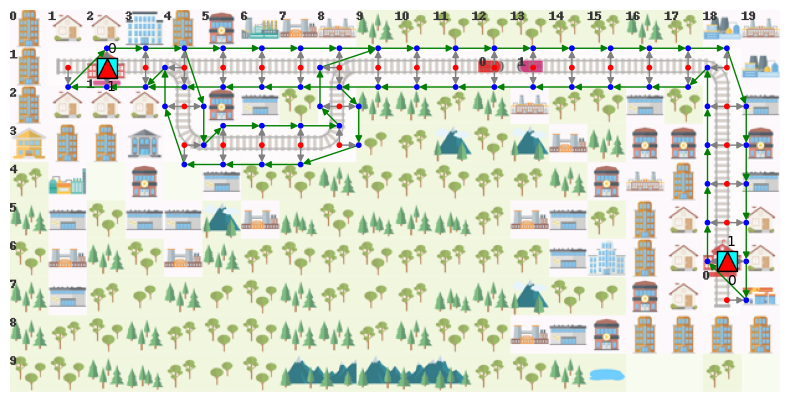

In [45]:
#plotGraphEnv(G2, env, aImg)
plotGraphEnv(G5, env, aImg, figsize=(10,10), node_size=10,
                space=0.5,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold"),
                #show_edge_weights=True,
                show_labels=(),
                alpha_img=0.8
               )
with io.BytesIO() as fbOut:
    plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
    bimgReduced = fbOut.getvalue()
#plt.close()

Here it is with the simple paths "reduced" into single edges.

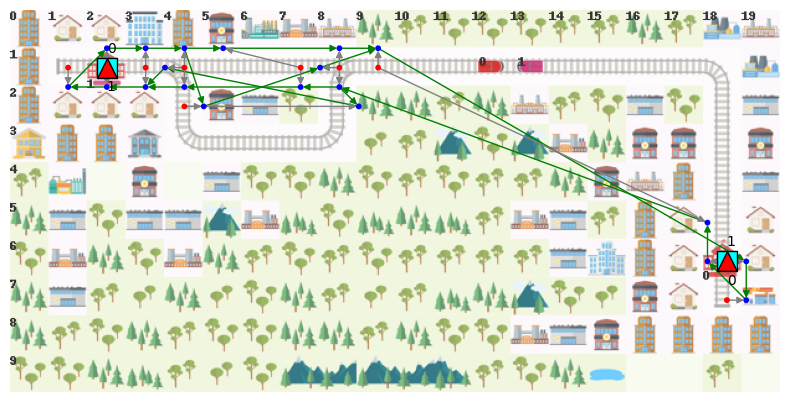

In [46]:
plotGraphEnv(oReg.reduce_simple_paths(), env, aImg, figsize=(10,10), node_size=10,
                space=0.5,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold"),
                #show_edge_weights=True,
                show_labels=(),
                alpha_img=0.8
               )

In [47]:
len(env.agents)

2

In [48]:
dlPos = {}
for agent in env.agents:
    l = dlPos.get(agent.initial_position, []) + [agent.handle]
    dlPos[agent.initial_position] = l

dlPos

{(1, 2): [0], (6, 18): [1]}

In [49]:
pilImg = Image.fromarray(aImg)

In [50]:
with io.BytesIO() as fOut:
    pilImg.save(fOut, format='PNG')
    byteImg = fOut.getvalue()

In [51]:
lwIm = [ ipw.Image(value=bim) for bim in [byteImg, 
                                          bimgEnv,
                                          bimgReduced]]

In [52]:
(lGpaths, llnPaths, lltStartTarg) = gu.genStartTargetDirs(G5, env)
#lwImPath = []
for iAgent, Gpath in enumerate(lGpaths):
    plotGraphEnv(Gpath, env, aImg, figsize=(10,10), node_size=10,
                space=0.1,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir"),
                show_labels=(),
                show_edge_weights=True,
                alpha_img=0.7
               )
    with io.BytesIO() as fbOut:
        plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
        bimgPath = fbOut.getvalue()
    plt.close()
    lwIm.append(ipw.Image(value=bimgPath))
    
    
    

# Pictures of graph, reduced graph, and shortest agent paths

In [54]:
tab = ipw.Tab(lwIm)
tab.set_title(0, "map")
tab.set_title(1, "graph")
tab.set_title(2, "reduced graph")
for i in range(len(env.agents)):
    tab.set_title(3+i, f"{i}")
tab

### Resource usage from shortest paths

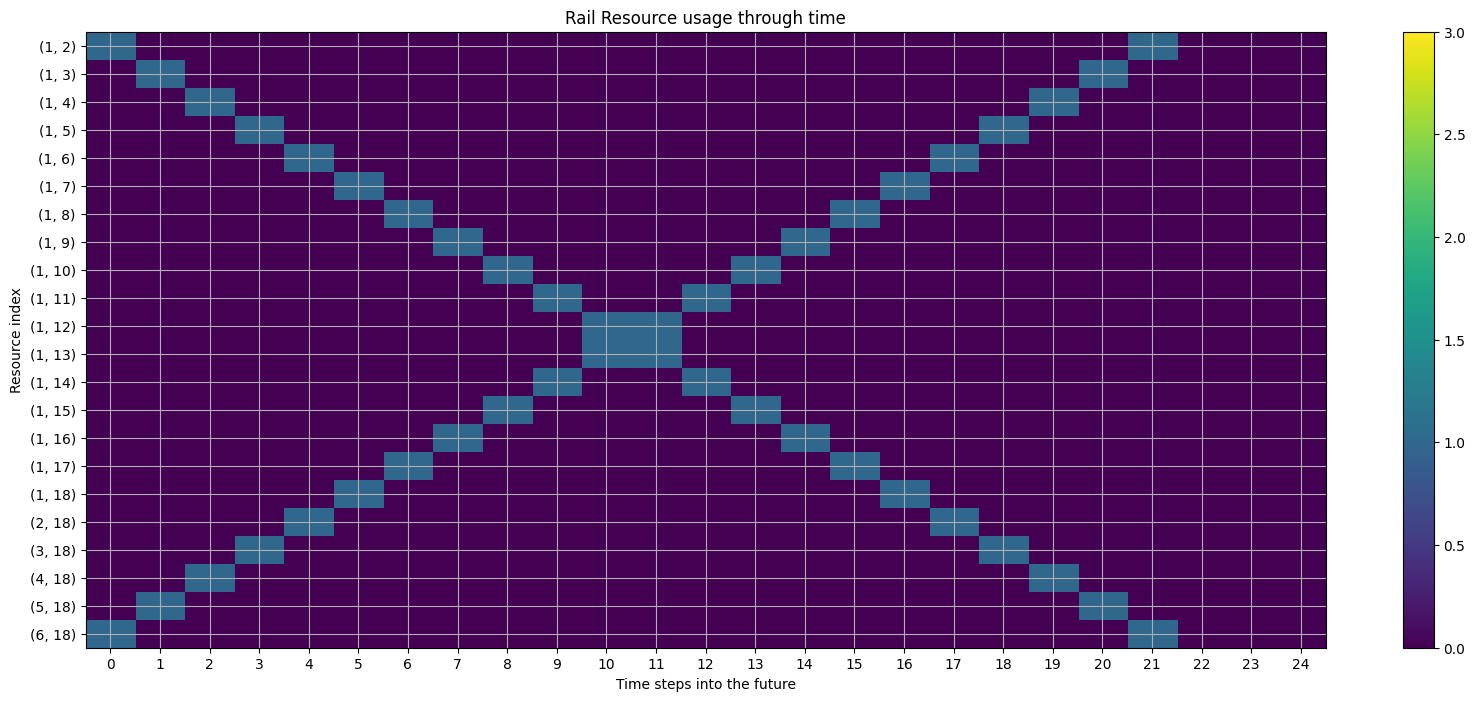

In [55]:
dResource, dlRails, dg2Dirs = gu.plotResourceUsage(
    G5, llnPaths, nSteps=100, nStepsShow=25, 
    contradir=False, node_ticks=range(25))
plt.xticks(range(25))
pass

### Hammock of Paths for each agent

In [37]:
dAgStTg = { iAgent:ltStTg for iAgent,ltStTg in enumerate(lltStartTarg)}

In [38]:
dlpiHammock = {}
numPaths=0
for iAgent, (nStart, nTarg) in dAgStTg.items():
    lpiHammock = gu.hammockPaths(G5, nStart, nTarg, endSkip=3, preamble=True, ratioMax=2)
    dlpiHammock[iAgent] = lpiHammock
    numPaths += len(lpiHammock)
    print(iAgent, nStart, nTarg, len(lpiHammock), [ oPI.length for oPI in lpiHammock ])
print(numPaths)

0 (1, 2, 1) (6, 18, 2) 2 [21.0, 25.0]
1 (6, 18, 0) (1, 2, 3) 2 [21.0, 25.0]
4


In [39]:
#dlpiHammock[3]

### Pictures of Hammock Paths for each agent

In [41]:
#### G5c = nx.compose_all([ nx.induced_subgraph(G5, lnPath) for lnPath in lllnHammock[0][:1] + lllnHammock[1][1:2] ])
lwIm = []
for iAgent, lpiHammock in list(dlpiHammock.items())[:10]: # range(len(env.agents)):
    G5c = nx.compose_all([ nx.induced_subgraph(G5, oPI.tPath) for oPI in lpiHammock ])
    gu.plotGraphEnv(G5c, env, aImg, node_size=2, figsize=(10,10), alpha_img=0.7, space=0, show_edge_weights=True)
    with io.BytesIO() as fbOut:
        plt.savefig(fbOut, bbox_inches="tight", pad_inches=0)
        bimgPath = fbOut.getvalue()
    plt.close()
    lwIm.append(ipw.Image(value=bimgPath))

oTab = ipw.Tab(lwIm)

list(map(oTab.set_title, *zip(*[(i, str(i)) for i in range(len(lwIm)) ])))
oTab

### scratch comparing paths / hammocks

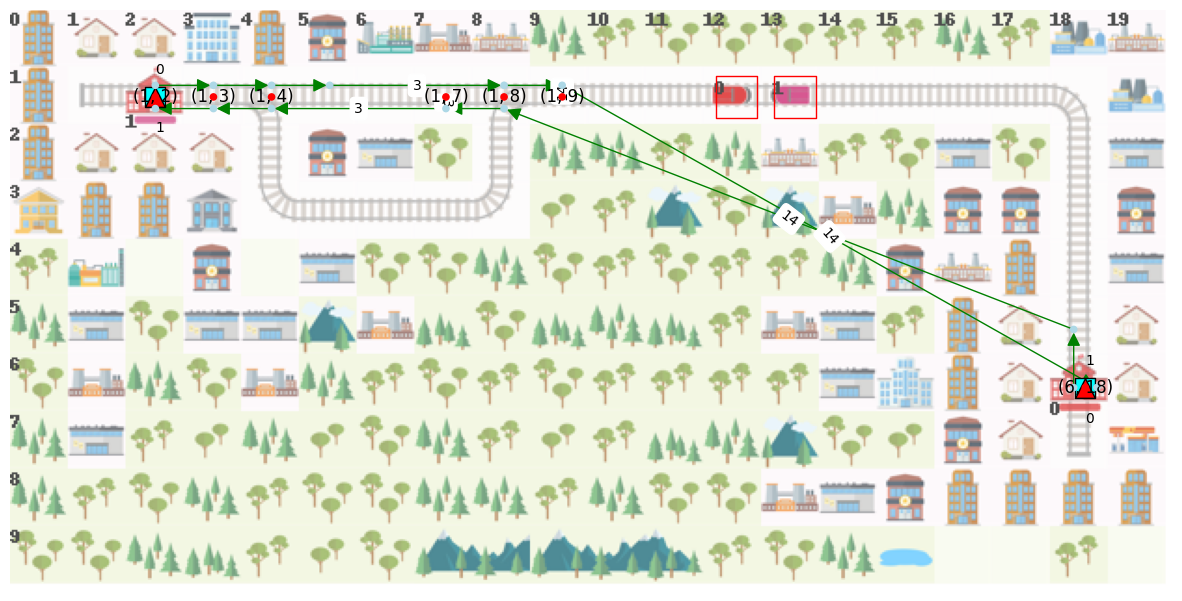

In [42]:
iAgent=0
lpiHammock = dlpiHammock[iAgent]
#G5c = nx.compose_all([ nx.induced_subgraph(G5, oPI.tPath) for oPI in lpiHammock[2:3] ])
#gu.plotGraphEnv(G5c, env, aImg, node_size=2, figsize=(10,10), alpha_img=0.7, space=0, show_edge_weights=True)

#G5c = nx.compose_all([ nx.induced_subgraph(G5, oPI.tPath) for oPI in lpiHammock[0:1] ])
oPI = lpiHammock[0]

oPI2 = dlpiHammock[1][0]

lnGrid = gu.grid_node_for_rails(G5, oPI.tPath)
G5c = nx.induced_subgraph(G5, oPI.tPath + lnGrid + oPI2.tPath) 
gu.plotGraphEnv(G5c, env, aImg, node_size=20, figsize=(15,15), alpha_img=0.7, space=0.2,
    show_edge_weights=True, show_labels=["grid"], show_edges=["dir",], show_nodes=["grid", "rail"], arrowsize=20,
    lvHighlight=[(1,12),(1,13)])
#[ (n,d) for n,d in G5c.nodes(data=True) if d["type"]=="grid" ]

In [34]:
#list(G5c.edges(data=True))

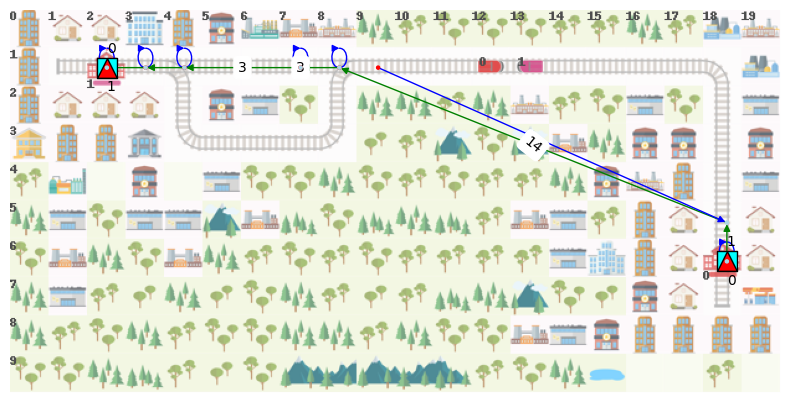

In [43]:
iAgent=1
lpiHammock = dlpiHammock[iAgent]
#G5c = nx.compose_all([ nx.induced_subgraph(G5, oPI.tPath) for oPI in lpiHammock[0:1] ])
oPI = lpiHammock[0]
lnGrid = gu.grid_node_for_rails(G5, oPI.tPath)
G5c = nx.induced_subgraph(G5, oPI.tPath + lnGrid) 

gu.plotGraphEnv(G5c, env, aImg, node_size=5, figsize=(10,10), alpha_img=0.7, space=0, show_edge_weights=True, show_edges=["dir","hold"])
#print(oPI.tPath)
#list(G5c.edges(data=True))
#[ (n,d) for n,d in G5c.nodes(data=True) if d["type"]=="grid" ]